# <span style="color:#56cfe1"> 1 - Download da base de dados do Supabase</span>

In [82]:
from dotenv import load_dotenv
import joblib
from matplotlib import pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import spacy
from supabase import create_client
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import KFold
import warnings


load_dotenv()

SUPABASE_URL = os.environ.get("SUPABASE_URL")
SUPABASE_KEY = os.environ.get("SUPABASE_KEY")
pd.set_option('display.max_columns', None)

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
query = supabase.table("wine_data").select("*").execute()
db_original = pd.DataFrame(query.data)

In [83]:
db = db_original.copy()

# <span style="color:#56cfe1">2 - Informações básica do DataFrame</span>

In [84]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   717 non-null    int64 
 1   product_type                         673 non-null    object
 2   product_name                         717 non-null    object
 3   wine_variety                         673 non-null    object
 4   wine_region                          717 non-null    object
 5   item_quantity                        717 non-null    object
 6   wine_grapes                          303 non-null    object
 7   color_description                    465 non-null    object
 8   scent_description                    464 non-null    object
 9   taste_description                    466 non-null    object
 10  fruit_tasting                        466 non-null    object
 11  sugar_tasting                        466 non-

In [85]:
db.describe()

,id
count,717.000000
mean,360.405858
std,209.145418
min,1.000000
25%,180.000000
50%,359.000000
75%,538.000000
max,725.000000


# <span style="color:#56cfe1">3 - Feature Engineering</span>

Uso	                    Cor (HEX)	Preview
Título Principal	   #56cfe1  	(Azul claro)
Subtítulo	           #f3722c 	    (Laranja intenso)
Seção	               #f9c74f      (Amarelo dourado)	
Destaque	           #90be6d      (Verde suave)	
Aviso	               #ff6b6b      (Vermelho vibrante)
Texto Secundário	   #bdb2ff          (Lilás claro)

## <span style="color:#f3722c">3.1 - <b>Feature: Item quantity</b></span> -> int

### <b>O que foi feito:</b> Limpeza dos valores, retornando apenas os números inteiros presentes em cada valor.
### <b>Resultado:</b> Foi criada uma feature com o numero de unidade com o tipo int o nome da coluna é: item_quantity_integer

In [86]:
db['item_quantity'].sort_values(ascending=False, key=lambda x: x.str.len())

117    12 unidades
58     10 unidades
154    10 unidades
66     12 unidades
122    10 unidades
          ...     
692              1
691              1
688              1
687              1
686              1
Name: item_quantity, Length: 717, dtype: object

In [87]:
db['item_quantity_integer'] = db['item_quantity'].str.split(" ").apply(lambda x: x[0]).astype(int)
db['item_quantity_integer']

0       1
1       1
2      10
3       1
4      10
       ..
712     3
713     1
714     3
715     1
716     1
Name: item_quantity_integer, Length: 717, dtype: int64

In [88]:
db['item_quantity_integer'].max()

np.int64(12)

In [89]:
db.drop("item_quantity", axis='columns', inplace=True)

## <span style="color:#f3722c">3.2 - <b>Feature: wine_variety</b></span> -> Filtrando resultados

### <b>O que foi feito:</b> Foram filtrados todos os registros com a variável wine_variety nula.
### <b>Resultado:</b> Entradas com wine_variety nulo foram retiradas do dataset.

In [90]:
db["wine_variety"].unique()

array(['Vinho tinto', 'Vinho rosé', 'Vinho branco', 'Vários tipos', None,
       'Espumante Branco', 'Espumante Rosé'], dtype=object)

In [91]:
db[db['wine_variety'].isna()].head()

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer
10,27,None,Baco | O Jogo dos Vinhos,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-23T17:59:51.461769,None,None,None,None,https://www.evino.com.br/product/jogo-baco-tab...,None,1
26,236,None,Taca de Acrilico Bordeaux Evino,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-23T21:14:31.24666,None,None,None,https://res.cloudinary.com/evino/image/upload/...,https://www.evino.com.br/product/taca-de-acril...,None,1
33,661,None,Pesto Genovês De Tommaso Exclusivo Evino - 160g,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-29T01:32:35.844978,None,None,None,None,None,None,1
37,665,None,BEG Modern & Tropical Brazilian Boutique Infus...,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-29T01:33:14.302136,None,None,None,None,None,None,1
60,686,None,Negroni Classico Bottled Cocktail - 375 mL,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-29T01:56:45.831922,None,None,None,None,None,None,1


In [92]:
db = db[db["wine_variety"].isna()==False]

## <span style="color:#f3722c">3.3 - <b>Feature: product_type</b></span> -> Filtragem dos dados

### <b>O que foi feito:</b> Foi realizada a retirada de dados scrapeados que eram kits de produtos e que, portanto, não possuíam os dados.
### <b>Resultado:</b> Foram 197 registros retirados do DataFrame principal.

In [93]:
db[db["product_type"]=="Kit"]

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer
2,646,Kit,"Kit 10 Malbecs Best Sellers por R$39,90 cada g...",Vinho tinto,Argentina,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T02:24:47.940844,None,None,None,None,None,None,10
4,648,Kit,"Kit 10 Vinhos Brancos por R$24,90 cada garrafa*",Vinho branco,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T02:25:20.456657,None,None,None,None,None,None,10
5,11,Kit,Kit Primitivos Best Sellers | 6 garrafas por R...,Vinho tinto,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T02:37:57.406997,None,None,None,None,https://www.evino.com.br/product/6-primitivos-...,None,6
6,1,Kit,Kit 3 Malbecs Best Sellers + Bolsa Térmica,Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T03:18:12.856299,None,None,None,None,https://www.evino.com.br/product/kit-3-malbecs...,None,4
7,638,Kit,Kit Lançamentos Italianos,Vários tipos,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T14:42:02.199078,None,None,None,None,None,None,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,344,Kit,Kit Vinhos Mais Vendidos de 2024,Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-23T22:59:07.27482,None,None,None,https://res.cloudinary.com/evino/image/upload/...,https://www.evino.com.br/product/kit-os-melhor...,None,4
635,447,Kit,Kit Linha Atardecer de Los Andes + Kit 6 Marca...,Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T00:55:01.854817,None,None,None,None,https://www.evino.com.br/product/kit-linha-ata...,None,5
689,25,Kit,"Kit 3 Espumantes Best Sellers por R$109,90 cad...",Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T02:38:13.208747,None,None,None,None,https://www.evino.com.br/product/kit-3-espuman...,None,3
696,102,Kit,Kit Primitivos di Manduria | 2 Casale Brondell...,Vinho tinto,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T02:41:25.57598,None,None,None,None,https://www.evino.com.br/product/kit-4-primiti...,None,4


In [94]:
db_kits = db[db['product_type']=="Kit"]
db = db[db['product_type']!="Kit"]

In [95]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476 entries, 0 to 716
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   476 non-null    int64 
 1   product_type                         476 non-null    object
 2   product_name                         476 non-null    object
 3   wine_variety                         476 non-null    object
 4   wine_region                          476 non-null    object
 5   wine_grapes                          303 non-null    object
 6   color_description                    465 non-null    object
 7   scent_description                    464 non-null    object
 8   taste_description                    466 non-null    object
 9   fruit_tasting                        466 non-null    object
 10  sugar_tasting                        466 non-null    object
 11  acidity_tasting                      466 non-null 

## <span style="color:#f3722c">3.4 - <b>Feature: wine_grapes e product_name</b></span> -> Filtragem dos dados

### <b>O que foi feito:</b> Parte dos dados que não possuíam informação de wine_grapes eram produtos que eram kits mas não tinham o product_type como kit, portanto filtramos e tiramos estes itens.
### <b>Resultado:</b> Retiramos 173 linhas que vieram com a palavra Kit no nome do produto e que não tinham a informação de wine_grapes

In [96]:
db["wine_grapes"].unique()

array(['Blend, Cinsault, Grenache, Syrah', 'Uvas variadas', 'Barbera',
       None, 'Cabernet Sauvignon', 'Blend', 'Siria, Fonte da Cal',
       'Primitivo', 'Tempranillo', 'Touriga Nacional',
       'Sangiovese, Merlot', 'Sauvignon Blanc', 'Negroamaro, Malvasia',
       'Carménère', 'Cabernet Sauvignon, Ciliegiolo, Sangiovese',
       'Aglianico, Negroamaro, Primitivo', 'Criolla',
       'Blend, Negroamaro, Uvas variadas', 'Bonarda', 'Malbec',
       'Cabernet Sauvignon, Merlot, Uvas variadas',
       'Jaén, Touriga Nacional, Aragonez', 'Tempranillo, Merlot, Syrah',
       'Montepulciano', 'Merlot', 'Torrontés', 'Pinot Grigio',
       'Arinto, Trajadura', 'Chardonnay', 'Garnacha, Syrah, Tempranillo',
       'Pinot Noir', 'Bobal', 'Blend, Tempranillo',
       'Garnacha, Tempranillo', 'Nebbiolo', 'Garnacha',
       'Grenache, Syrah, Tempranillo',
       'Blend, Chardonnay, Chenin Blanc, Torrontés', 'Syrah', 'Airén',
       'Barbera, Dolcetto, Freisa, Bonarda, Albarossa, Merlot, Syrah, C

In [97]:
db[db["wine_grapes"].isna()]

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer
8,641,Vinho tinto francês,Kit Leve 6 Pague 3 Cave de Ladac Grand d'Excel...,Vinho tinto,França,None,None,None,None,None,None,None,None,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,None,None,França,Bordeaux,13%,"Merlot, Cabernet Sauvignon",E.L.G,2022,None,None,2025-03-27T14:42:28.623472,None,None,None,None,None,None,6
13,649,Espumante Branco espanhol,"Kit 9 Tanggier Brut por R$33,32 cada garrafa",Espumante Branco,Espanha,None,Amarelo-palha,"Notas de pêra, pêssego e minerais","Corpo leve, delicado, com muita fruta",4,2,3,1,"Saladas e aperitivos, Carnes brancas, Frutos d...",Espumante Branco,750ml,Rolha,9ºC,Espanha,Multirregional,10%,Uvas variadas,None,None,2025,None,2025-03-27T15:06:44.16999,None,Ari Gorenstein,Sommelier da evino,None,None,None,9
22,653,Vinho tinto italiano,Kit 2 Cuvée 16 Limited Edition Vino Rosso d'It...,Vinho tinto,Itália,None,Vermelho-rubi profundo com reflexos violáceos,"Intenso e complexo, com notas de compotas de f...","Aveludado, redondo, frutado, taninos macios e ...",4,1,2,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Multirregional,16%,Uvas variadas,None,None,None,None,2025-03-29T00:39:14.983701,None,Vinícius Santiago,Sommelier da evino,None,None,None,2
24,654,Vinho tinto português,Kit 3 Solouro Tinto,Vinho tinto,Portugal,None,Vermelho-granada intenso,Notas intensas de frutas vermelhas e pretas ma...,"Encorpado, redondo e frutado, com taninos marc...",3,1,3,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,15ºC,Portugal,None,12%,"Touriga Franca, Tinta Roriz",None,None,2025,None,2025-03-29T00:43:28.54111,None,Ari Gorenstein,Sommelier da evino,None,None,None,3
27,657,Espumante Branco espanhol,Kit 6 Tanggier Brut*,Espumante Branco,Espanha,None,Amarelo-palha,"Notas de pêra, pêssego e minerais","Corpo leve, delicado, com muita fruta",4,2,3,1,"Saladas e aperitivos, Carnes brancas, Frutos d...",Espumante Branco,750ml,Rolha,9ºC,Espanha,Multirregional,10%,Uvas variadas,None,None,2025,None,2025-03-29T00:49:00.719741,None,Ari Gorenstein,Sommelier da evino,None,None,None,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,285,Vinho tinto italiano,Kit 4 Infinitum Montepulciano d'Abruzzo DOC po...,Vinho tinto,Itália,None,Vermelho-rubi,Notas de cerejas maduras e amoras,"Equilibrado e encorpado, com taninos macios",3,1,3,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha,16ºC,Itália,Abruzzo,12.5%,Montepulciano,Deangeli Musti Nobilis,None,2025,None,2025-03-24T03:20:25.177931,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-4-vini-de...,None,4
710,306,Vinho tinto italiano,Kit 3 Conte Parelli Appassimento Puglia IGT po...,Vinho tinto,Itália,None,Vermelho-rubi intenso com reflexos violáceos,"Notas intensas de frutas vermelhas maduras, e ...","Elegante e harmonioso, com taninos aveludados ...",4,2,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Puglia,15%,"Blend, Negroamaro, Uvas variadas",Angelo Rocca e Figli Srl,2021,2025,Estágio em barricas de carvalho francês,2025-03-24T03:21:06.626014,None,Vinícius Santiago,Sommelier da evino,None,ht

In [98]:
db["product_name_with_word_kit"] = db['product_name'].str.contains("Kit", case=False)

In [99]:
db[db["product_name_with_word_kit"]==True].info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, 8 to 714
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   173 non-null    int64 
 1   product_type                         173 non-null    object
 2   product_name                         173 non-null    object
 3   wine_variety                         173 non-null    object
 4   wine_region                          173 non-null    object
 5   wine_grapes                          0 non-null      object
 6   color_description                    170 non-null    object
 7   scent_description                    169 non-null    object
 8   taste_description                    170 non-null    object
 9   fruit_tasting                        170 non-null    object
 10  sugar_tasting                        170 non-null    object
 11  acidity_tasting                      170 non-null 

In [100]:
pd.set_option('display.max_columns', None)
db[db["product_name_with_word_kit"]==True]

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer,product_name_with_word_kit
8,641,Vinho tinto francês,Kit Leve 6 Pague 3 Cave de Ladac Grand d'Excel...,Vinho tinto,França,None,None,None,None,None,None,None,None,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,None,None,França,Bordeaux,13%,"Merlot, Cabernet Sauvignon",E.L.G,2022,None,None,2025-03-27T14:42:28.623472,None,None,None,None,None,None,6,True
13,649,Espumante Branco espanhol,"Kit 9 Tanggier Brut por R$33,32 cada garrafa",Espumante Branco,Espanha,None,Amarelo-palha,"Notas de pêra, pêssego e minerais","Corpo leve, delicado, com muita fruta",4,2,3,1,"Saladas e aperitivos, Carnes brancas, Frutos d...",Espumante Branco,750ml,Rolha,9ºC,Espanha,Multirregional,10%,Uvas variadas,None,None,2025,None,2025-03-27T15:06:44.16999,None,Ari Gorenstein,Sommelier da evino,None,None,None,9,True
22,653,Vinho tinto italiano,Kit 2 Cuvée 16 Limited Edition Vino Rosso d'It...,Vinho tinto,Itália,None,Vermelho-rubi profundo com reflexos violáceos,"Intenso e complexo, com notas de compotas de f...","Aveludado, redondo, frutado, taninos macios e ...",4,1,2,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Multirregional,16%,Uvas variadas,None,None,None,None,2025-03-29T00:39:14.983701,None,Vinícius Santiago,Sommelier da evino,None,None,None,2,True
24,654,Vinho tinto português,Kit 3 Solouro Tinto,Vinho tinto,Portugal,None,Vermelho-granada intenso,Notas intensas de frutas vermelhas e pretas ma...,"Encorpado, redondo e frutado, com taninos marc...",3,1,3,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,15ºC,Portugal,None,12%,"Touriga Franca, Tinta Roriz",None,None,2025,None,2025-03-29T00:43:28.54111,None,Ari Gorenstein,Sommelier da evino,None,None,None,3,True
27,657,Espumante Branco espanhol,Kit 6 Tanggier Brut*,Espumante Branco,Espanha,None,Amarelo-palha,"Notas de pêra, pêssego e minerais","Corpo leve, delicado, com muita fruta",4,2,3,1,"Saladas e aperitivos, Carnes brancas, Frutos d...",Espumante Branco,750ml,Rolha,9ºC,Espanha,Multirregional,10%,Uvas variadas,None,None,2025,None,2025-03-29T00:49:00.719741,None,Ari Gorenstein,Sommelier da evino,None,None,None,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,285,Vinho tinto italiano,Kit 4 Infinitum Montepulciano d'Abruzzo DOC po...,Vinho tinto,Itália,None,Vermelho-rubi,Notas de cerejas maduras e amoras,"Equilibrado e encorpado, com taninos macios",3,1,3,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha,16ºC,Itália,Abruzzo,12.5%,Montepulciano,Deangeli Musti Nobilis,None,2025,None,2025-03-24T03:20:25.177931,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-4-vini-de...,None,4,True
710,306,Vinho tinto italiano,Kit 3 Conte Parelli Appassimento Puglia IGT po...,Vinho tinto,Itália,None,Vermelho-rubi intenso com reflexos violáceos,"Notas intensas de frutas vermelhas maduras, e ...","Elegante e harmonioso, com taninos aveludados ...",4,2,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Puglia,15%,"Blend, Negroamaro, Uvas variadas",Angelo Rocca e Figli Srl,2021,2025,Estágio em barricas de carvalho francês,2025-03-24T03:2

In [101]:
db[db["product_name"].str.contains("African Horizon Pinotage Western")]

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer,product_name_with_word_kit
159,40,Vinho tinto sul-africano,Kit 3 The African Horizon Pinotage Western Cap...,Vinho tinto,África do Sul,None,Vermelho-rubi,"Notas de frutas vermelhas, como cereja e grose...","Frutado e suculento, ressaltando taninos macio...",3,1,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Tampa de rosca,15ºC,África do Sul,Western Cape,13%,Pinotage,Origin Wine,2023,2025,None,2025-03-23T18:03:31.029735,None,Vinícius Santiago,Sommelier da evino,https://res.cloudinary.com/evino/image/upload/...,https://www.evino.com.br/product/kit-3-origin-...,None,3,True
667,543,Vinho tinto sul-africano,The African Horizon Pinotage Western Cape W.O....,Vinho tinto,África do Sul•,Pinotage,Vermelho-rubi,"Notas de frutas vermelhas, como cereja e grose...","Frutado e suculento, ressaltando taninos macio...",3,1,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Tampa de rosca,15ºC,África do Sul,Western Cape,13%,Pinotage,Origin Wine,2023,2025,None,2025-03-24T01:58:16.95541,"Uva tinta mais famosa da África do Sul, a Pino...",Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/origin-wine-t...,None,1,False


<span style="color:#ff6b6b">⚠️ Observação: </span>
Como as entradas são identicas mas com menos volume de informações, por exemplo: em kits de produtos tem as avaliações de força de acidez, nível de fruta e etc mas não tem a avaliação do especialista. Talvez seja improtante retirar essas entradas do dataframe principal, assim como fiz com os kits e separá-las num outro df que juntarei com o df dos kits.

In [102]:
db_kits_from_product_name = db[db['product_name_with_word_kit']==True]
db = db[db['product_name_with_word_kit']==False]


db_all_kits = pd.concat([db_kits, db_kits_from_product_name], axis=0,ignore_index=True)

In [103]:
db_all_kits

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer,product_name_with_word_kit
0,646,Kit,"Kit 10 Malbecs Best Sellers por R$39,90 cada g...",Vinho tinto,Argentina,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T02:24:47.940844,None,None,None,None,None,None,10,NaN
1,648,Kit,"Kit 10 Vinhos Brancos por R$24,90 cada garrafa*",Vinho branco,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T02:25:20.456657,None,None,None,None,None,None,10,NaN
2,11,Kit,Kit Primitivos Best Sellers | 6 garrafas por R...,Vinho tinto,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T02:37:57.406997,None,None,None,None,https://www.evino.com.br/product/6-primitivos-...,None,6,NaN
3,1,Kit,Kit 3 Malbecs Best Sellers + Bolsa Térmica,Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T03:18:12.856299,None,None,None,None,https://www.evino.com.br/product/kit-3-malbecs...,None,4,NaN
4,638,Kit,Kit Lançamentos Italianos,Vários tipos,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T14:42:02.199078,None,None,None,None,None,None,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,285,Vinho tinto italiano,Kit 4 Infinitum Montepulciano d'Abruzzo DOC po...,Vinho tinto,Itália,None,Vermelho-rubi,Notas de cerejas maduras e amoras,"Equilibrado e encorpado, com taninos macios",3,1,3,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha,16ºC,Itália,Abruzzo,12.5%,Montepulciano,Deangeli Musti Nobilis,None,2025,None,2025-03-24T03:20:25.177931,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-4-vini-de...,None,4,True
366,306,Vinho tinto italiano,Kit 3 Conte Parelli Appassimento Puglia IGT po...,Vinho tinto,Itália,None,Vermelho-rubi intenso com reflexos violáceos,"Notas intensas de frutas vermelhas maduras, e ...","Elegante e harmonioso, com taninos aveludados ...",4,2,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Puglia,15%,"Blend, Negroamaro, Uvas variadas",Angelo Rocca e Figli Srl,2021,2025,Estágio em barricas de carvalho francês,2025-03-24T03:21:06.626014,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-3-conte-p...,None,3,True
367,354,Espumante Branco francês,Kit 4 Première Bulle Blanquette de Limoux AOC ...,Espumante Branco,França,None,Dourado pálido com perlages finos,Aromas delicados de frutas cítricas e flores b...,"Vivaz e redondo, com textura agradável, notas ...",3,1,4,1,"Carnes brancas, Frutos do mar, Risoto e massas...",Espumante Branco,750ml,Rolha de cortiça,6ºC,França,Languedoc-Roussillon,12.5%,"Mauzac, Chardonnay, Chenin Blanc",Sieur d'Arques,None,2025,Envelhecimento sobre as borras por 18 meses,2025-03-24T03:22:08.758223,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-4-premier...,None,4,True
368,383,Vinho branco sul-africano,Kit 3 The African Horizon Chenin Blanc Western...,Vinho branco,África 

## <span style="color:#f3722c">3.5 - <b>Feature: wine_grapes e technical_sheet_grapes</b></span>

### <b>O que foi feito:</b> Foi realizada a retirada de dados scrapeados que eram kits de produtos e que, portanto, não possuíam os dados.
### <b>Resultado:</b> Desconsideramos uma das duas colunas dado que os valores são todos iguais.

In [104]:
db[['wine_grapes', "technical_sheet_grapes"]]

,wine_grapes,technical_sheet_grapes
0,"Blend, Cinsault, Grenache, Syrah","Blend, Cinsault, Grenache, Syrah"
1,Uvas variadas,Uvas variadas
3,Barbera,Barbera
11,Cabernet Sauvignon,Cabernet Sauvignon
21,Blend,Blend
...,...,...
707,Malbec,Malbec
708,Grenache,Grenache
713,Nebbiolo,Nebbiolo
715,Blend,Blend


In [105]:
db['wine_grapes_equal_tech_sheet'] = db['wine_grapes']==db['technical_sheet_grapes']
db['wine_grapes_equal_tech_sheet'].value_counts()

wine_grapes_equal_tech_sheet
True    303
Name: count, dtype: int64

In [106]:
db.drop("wine_grapes", axis='columns', inplace=True)

<span style="color:#ff6b6b">⚠️ Observação:</span> Podemos desconsiderar uma das duas colunas dado que os valores são todos iguais.

## <span style="color:#f3722c">3.6 - <b>Feature: product_type, wine_variety e technical_sheet_wine_type</b></span>

### <b>O que foi feito:</b> Analisamos as informaçõs contidas nessas 3 colunas. Verificamos que wine_variety e technical_sheet_wine_type eram iguais. Retiramos uma delas. A variável product_type e uma informação mais detalhada.
### <b>Resultado:</b> Removemos a coluna wine_variety por ser igual à coluna technical_sheet_wine_type

In [107]:
db[["product_type", "wine_variety", "technical_sheet_wine_type"]]

,product_type,wine_variety,technical_sheet_wine_type
0,Vinho tinto francês,Vinho tinto,Vinho tinto
1,Vinho rosé português,Vinho rosé,Vinho rosé
3,Vinho tinto italiano,Vinho tinto,Vinho tinto
11,Vinho tinto argentino,Vinho tinto,Vinho tinto
21,Vinho rosé chileno,Vinho rosé,Vinho rosé
...,...,...,...
707,Vinho tinto argentino,Vinho tinto,Vinho tinto
708,Espumante Rosé brasileiro,Espumante Rosé,Espumante Rosé
713,Vinho tinto italiano,Vinho tinto,Vinho tinto
715,Vinho tinto chileno,Vinho tinto,Vinho tinto


In [108]:
db["product_type"].unique()

array(['Vinho tinto francês', 'Vinho rosé português',
       'Vinho tinto italiano', 'Vinho tinto argentino',
       'Vinho rosé chileno', 'Vinho branco português',
       'Vinho rosé espanhol', 'Vinho tinto chileno',
       'Vinho branco argentino', 'Vinho tinto português',
       'Vinho branco chileno', 'Espumante Branco francês',
       'Espumante Branco brasileiro', 'Vinho rosé argentino',
       'Vinho tinto espanhol', 'Vinho branco sul-africano',
       'Vinho tinto europeu', 'Vinho rosé europeu',
       'Espumante Branco espanhol', 'Vinho branco italiano',
       'Vinho branco espanhol', 'Vinho rosé sul-africano',
       'Vinho rosé italiano', 'Espumante Rosé francês',
       'Vinho branco francês', 'Espumante Rosé espanhol',
       'Espumante Branco argentino', 'Espumante Rosé brasileiro',
       'Vinho rosé francês', 'Vinho tinto sul-africano',
       'Vinho branco brasileiro'], dtype=object)

A variável product_type é uma informação mais detalhada das outras duas variáveis

In [109]:
db['wine_variety_equal_tech_sheet'] = db['wine_variety']==db['technical_sheet_wine_type']
db['wine_grapes_equal_tech_sheet'].value_counts()

wine_grapes_equal_tech_sheet
True    303
Name: count, dtype: int64

In [110]:
db.drop("wine_variety", axis='columns', inplace=True)

Também podemos desconsiderar uma das duas variáveis dado que elas são iguais.

## <span style="color:#f3722c">3.7 - <b>Feature: wine_region, technical_sheet_region e technical_sheet_country</b></span>

### <b>O que foi feito:</b> Analisamos as informaçõs contidas nessas 3 colunas. Verificamos que wine_region e technical_sheet_country eram iguais. Retiramos uma delas. A variável technical_sheet_region e uma informação mais detalhada.
### <b>Resultado:</b> Removemos a coluna wine_region por ser igual à coluna technical_sheet_wine_type

In [111]:
db[['wine_region', 'technical_sheet_region', 'technical_sheet_country']].head(5)

,wine_region,technical_sheet_region,technical_sheet_country
0,França•,Vale do Rhône,França
1,Portugal•,Multirregional,Portugal
3,Itália•,Piemonte,Itália
11,Argentina•,Mendoza,Argentina
21,Chile•,Valle del Maule,Chile


In [112]:
db['wine_region'] = db['wine_region'].str.replace("•", "")

In [113]:
db[['wine_region','technical_sheet_country']].value_counts()

wine_region    technical_sheet_country
Argentina      Argentina                  72
Chile          Chile                      70
Espanha        Espanha                    48
Itália         Itália                     42
Portugal       Portugal                   23
França         França                     18
Europeu        Europeu                    14
Brasil         Brasil                     11
África do Sul  África do Sul               5
Name: count, dtype: int64

In [114]:
db['wine_region_equal_tech_sheet'] = db['wine_region']==db['technical_sheet_country']
db['wine_region_equal_tech_sheet'].value_counts()

wine_region_equal_tech_sheet
True    303
Name: count, dtype: int64

In [115]:
db[['wine_region','technical_sheet_country']].head(5)

,wine_region,technical_sheet_country
0,França,França
1,Portugal,Portugal
3,Itália,Itália
11,Argentina,Argentina
21,Chile,Chile


In [116]:
db.drop("wine_region", axis='columns', inplace=True)

Podemos desconsiderar uma das duas variáveis 'wine_region' ou'technical_sheet_country' dado que são iguais.

## <span style="color:#f3722c">3.8 - <b>Feature: fruit_tasting, tannin_tasting, sugar_tasting e acidity_tasting</b></span>

### <b>O que foi feito:</b> Verificação sobre valores nulos em variáveis que seriam utilizadas no modelo.
### <b>Resultado:</b> Desconsideramos todas os registros (7) que não possuíam informação de sensação e transformamos os valores em inteiros.

In [117]:
db.loc[db['fruit_tasting'].isna()==True]['id'].tolist()

[559, 238, 261, 499, 460, 557, 42]

In [118]:
db.loc[db['tannin_tasting'].isna()==True]['id'].tolist()

[559, 238, 261, 499, 460, 557, 42]

In [119]:
db.loc[db['sugar_tasting'].isna()==True]['id'].tolist()

[559, 238, 261, 499, 460, 557, 42]

In [120]:
db.loc[db['acidity_tasting'].isna()==True]['id'].tolist()

[559, 238, 261, 499, 460, 557, 42]

<span style="color:#ff6b6b">⚠️ Observação:</span> Como todos os itens que não possuem avaliação são os mesmos, a melhor alternativa é tirá-los para não serem um problema no modelo de machine learning.

In [121]:
db = db.loc[db['acidity_tasting'].isna()==False]

In [122]:
db['id'].count()

np.int64(296)

In [123]:
db[['fruit_tasting','sugar_tasting', 
    'acidity_tasting', 'tannin_tasting']] = db[['fruit_tasting','sugar_tasting', 
                                                'acidity_tasting', 'tannin_tasting']].astype(int)

## <span style="color:#f3722c">3.9 - <b>Feature: product_name</b></span>

### <b>O que foi feito:</b> Investigamos se ainda havia necessidade de alguma limpeza dos dados através desta coluna.
### <b>Resultado:</b> Após as exclusões anteriores, agora esta feature não possui mais nomes "sujos", portanto não será necessário realizar nenhum tipo de limpeza aqui.

In [124]:
db['product_name'].unique()

array(['La Chaise des Papes Châteauneuf-du-Pape AOC 2022',
       'Travessia Rosé',
       'Stardust Edição Limitada Taurus Rosso Piemonte DOC 2020',
       'La Grupa Cabernet Sauvignon Gran Selección 2023',
       'San Nazareno Winemaker Selection Rosé 2024', 'Travessia Branco',
       'San Cristaldo in Fonteroma Primitivo Di Puglia 2021',
       'Castillo De Soldepeñas Rosado Tempranillo',
       'El Origen Winemaker Selection del Limarí Cabernet Sauvignon 2024',
       'Las Colinas de Los Andes White Blend 2024',
       "Grand'Arte Touriga Nacional Vinho Regional Lisboa 2019",
       'Stardust Edição Limitada Sagittarius Rosso Toscana IGT 2020',
       'Playa Azul Winemaker Selection Sauvignon Blanc Central Valley D.O. 2023',
       'Aves Del Sur Cabernet Sauvignon Valle del Loncomilla D.O. 2023',
       'Lupo Meraviglia Due di Due Rosso di Puglia IGT 2022',
       'Champagne Veuve Clicquot Brut',
       'Lagunas Rosé Valle Central D.O. 2024',
       'Champagne Armand de Brignac “Ac

<span style="color:#ff6b6b">⚠️ Observação:</span>  Essa feature contém os nomes corretos, uma vez que tiramos os kits e demais sujeiras do dataset. Não é necessário fazer nada aqui.

## <span style="color:#f3722c">3.10 - <b>Feature: technical_sheet_service_temperature</b></span> -> technical_sheet_service_temperature_in_celsius

### <b>O que foi feito:</b> As temperaturas estavam em strings com "ºC" sempre, fizemos uma limpeza para retirar e criamos uma nova coluna.
### <b>Resultado:</b> Coluna de temperatura tratada para possível uso posterior.

In [125]:
db["technical_sheet_service_temperature"] = db["technical_sheet_service_temperature"].str.replace("ºC", "")
db.rename(columns={'technical_sheet_service_temperature': 'technical_sheet_service_temperature_in_celsius'}, inplace=True)
db['technical_sheet_service_temperature_in_celsius']

0      16
1      10
3      18
11     18
21      8
       ..
707    18
708     9
713    17
715    16
716    18
Name: technical_sheet_service_temperature_in_celsius, Length: 296, dtype: object

## <span style="color:#f3722c">3.11 - <b>Feature: technical_sheet_alcohol_content</b></span>

### <b>O que foi feito:</b> Os dados de concentração alcóolica estavam em strings com "%" sempre, fizemos uma limpeza para retirar e substituímos os valores da coluna.
### <b>Resultado:</b> Coluna de concentração alcóolica tratada para possível uso posterior

In [126]:
db["technical_sheet_alcohol_content"] = db["technical_sheet_alcohol_content"].str.replace("%","")
db["technical_sheet_alcohol_content"]

0        15
1      11.5
3      13.5
11       13
21     12.5
       ... 
707    12.5
708      12
713      14
715    12.5
716    13.5
Name: technical_sheet_alcohol_content, Length: 296, dtype: object

# <span style="color:#56cfe1">4 - Análise Exploratória dos Dados</span>

In [127]:
# Gerando uma cópia para poder manipular livremente
eda_df = db.copy()
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 716
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   id                                              296 non-null    int64 
 1   product_type                                    296 non-null    object
 2   product_name                                    296 non-null    object
 3   color_description                               295 non-null    object
 4   scent_description                               295 non-null    object
 5   taste_description                               296 non-null    object
 6   fruit_tasting                                   296 non-null    int64 
 7   sugar_tasting                                   296 non-null    int64 
 8   acidity_tasting                                 296 non-null    int64 
 9   tannin_tasting                                  296 non-nul

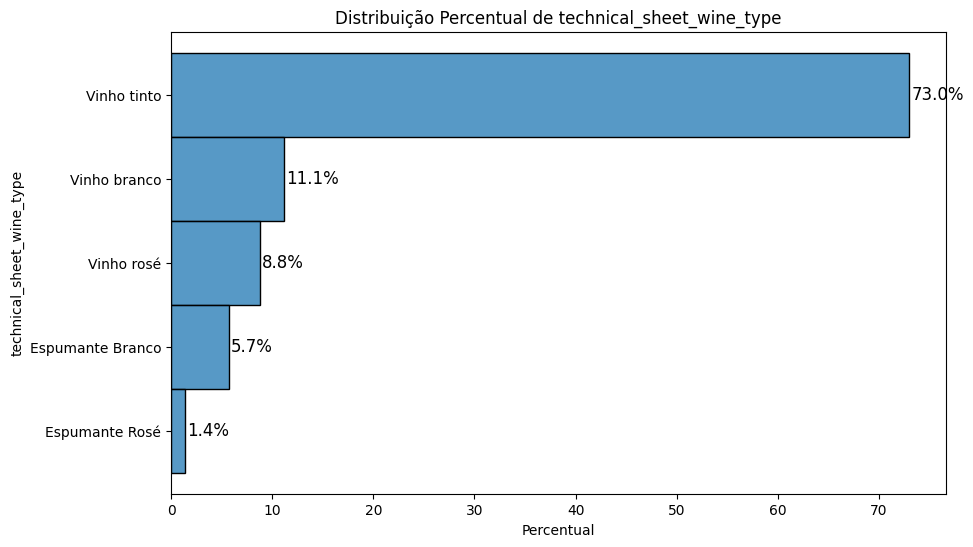

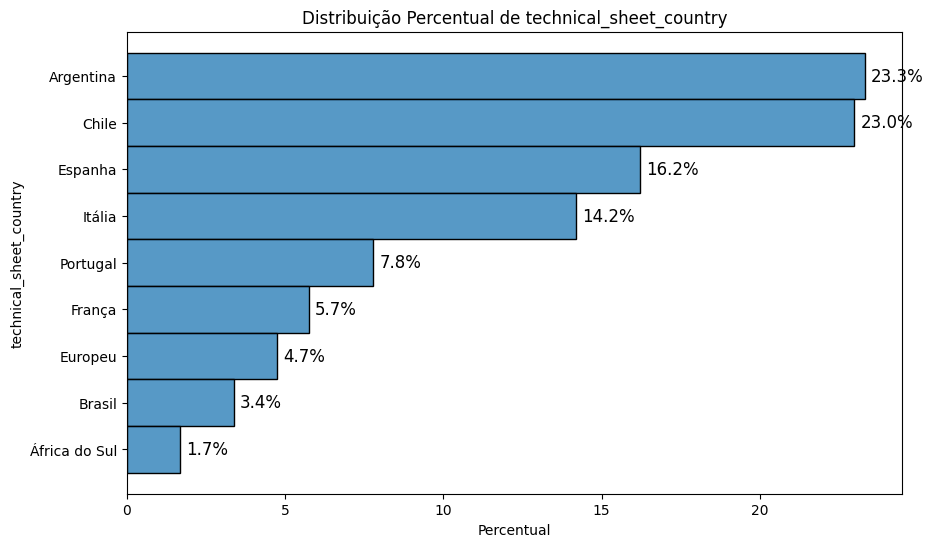

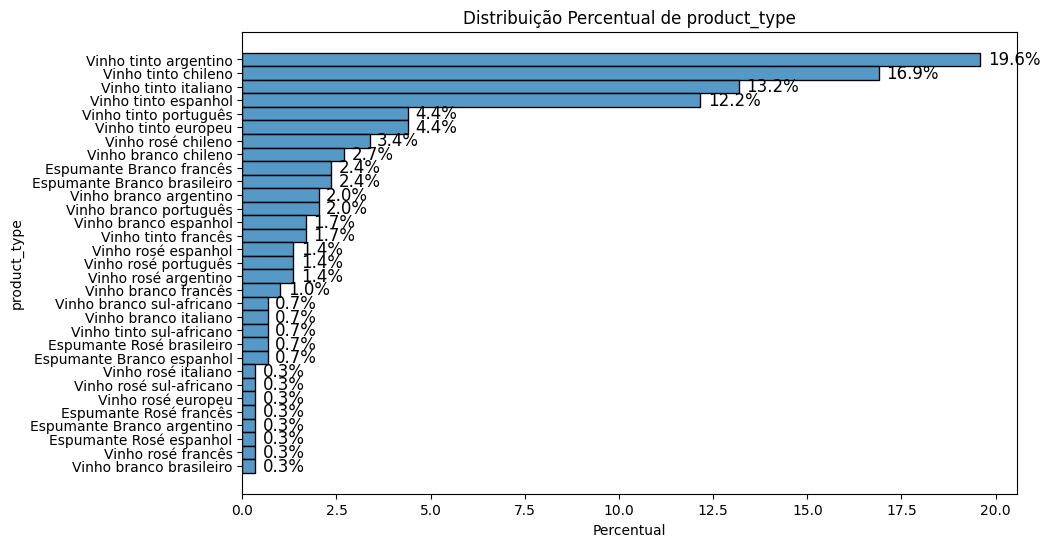

In [128]:
columns = ['technical_sheet_wine_type', 'technical_sheet_country', 'product_type']


# Gerar a distribuição percentual de cada valor para cada uma das colunas 
for col in columns:
    sorted_counts = eda_df[col].value_counts().sort_values(ascending=False)
    total = sorted_counts.sum() 
    
    sorted_df = eda_df[eda_df[col].isin(sorted_counts.index)].copy()
    sorted_df[col] = sorted_df[col].astype("category")
    sorted_df[col] = sorted_df[col].cat.set_categories(sorted_counts.index, ordered=True)

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = sns.histplot(data=sorted_df, y=col, kde=False, discrete=True, 
                        cumulative=False, multiple='stack', stat='percent', ax=ax)

    for bar, count in zip(bars.patches, sorted_counts.values):
        percent = (count / total) * 100  
        ax.text(bar.get_width()+0.2,  
                bar.get_y() + bar.get_height() / 2,  
                f"{percent:.1f}%", 
                va='center', ha='left', fontsize=12, color='black')

    plt.title(f"Distribuição Percentual de {col}")
    plt.xlabel("Percentual")
    plt.ylabel(col)
    plt.show()

<span style="color:#90be6d">💡 Nota:</span>

É possível perceber que temos dados não balanceados para algumas das nossas features estão bem desbalanceadas:

* Vinho tinto domina os vinhos disponíveis no site da Evino, com 73% dos vinhos coletados; 
* Argentina e Chile são países dominantes na produção de vinhos e isso é refletido também na amostra de vinhos que coletamos do site;
* A diferença entre as nacionalidades é refletida também nos dados quando descemos um nível de segmentação dos vinhos por nacionalidade e por tipo.

Certamente devemos ter cuidado com a base devido a essas características de desbalanceamento.


Agora vamos analisar os índices de avaliação sensoriais:

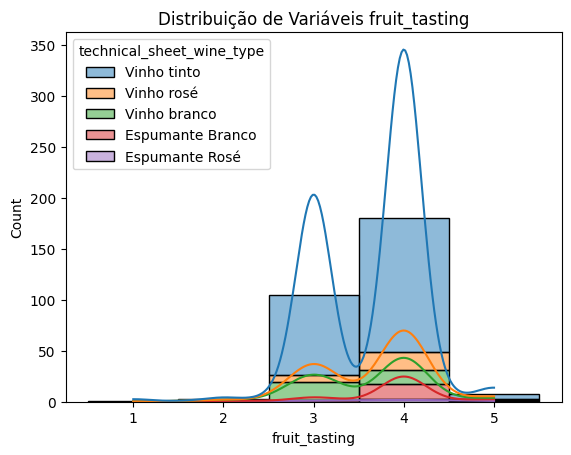

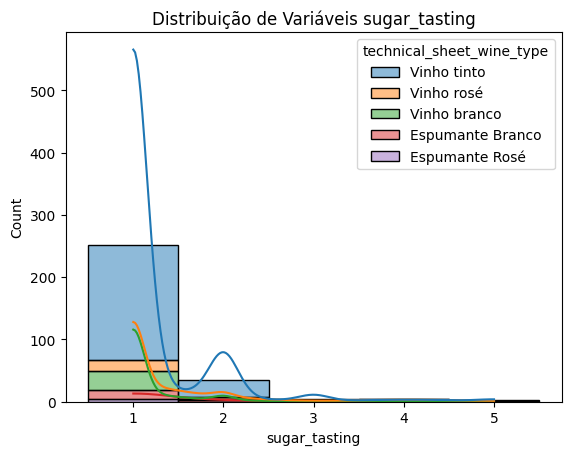

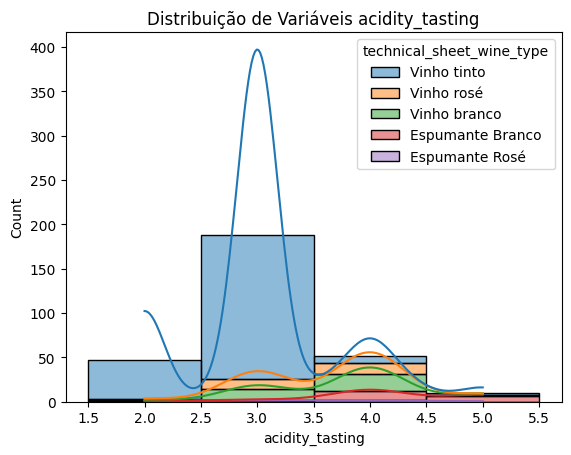

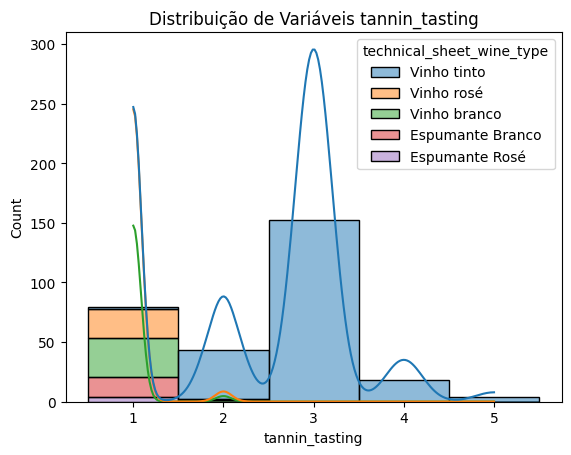

In [129]:
columns = ['fruit_tasting', 'sugar_tasting', 'acidity_tasting', 'tannin_tasting',]

for col in columns:
    
    sns.histplot(data=eda_df , x=col, kde=True, 
                 discrete=True, cumulative=False, stat='count',
                 multiple='stack', hue='technical_sheet_wine_type')\
                .set_title(f"Distribuição de Variáveis {col}")
    plt.show()

<span style="color:#90be6d">💡 Nota:</span>

Podemos perceber que nem todas as 4 variáveis tem uma boa dispersão dos valores de acidez, tanino, açúcar e fruta. 
Isso nos mostra que há uma concentração de quem fez a avaliação por parte da fonte dos dados (Evino) e, para nós, é um ponto de atenção dada essa concentração o como vamos fazer para poder considerar esta variáveis como input de um possível modelo.

C:\Users\victo\AppData\Local\Temp\ipykernel_32584\4192198635.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=real_counts.head(20), y="combination", x="count", palette="viridis")


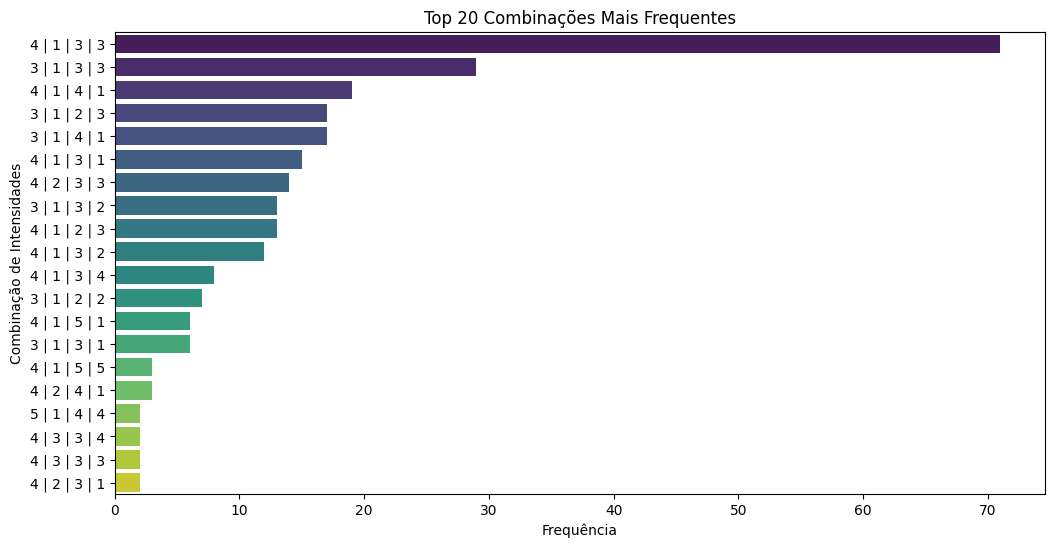

In [130]:
columns = ['fruit_tasting', 'sugar_tasting', 'acidity_tasting', 'tannin_tasting',]

real_counts = eda_df[columns].value_counts().reset_index()
real_counts.columns = columns + ["count"]
real_counts["combination"] = real_counts[columns].astype(str).agg(" | ".join, axis=1)
real_counts = real_counts.sort_values(by="count", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=real_counts.head(20), y="combination", x="count", palette="viridis")

plt.xlabel("Frequência")
plt.ylabel("Combinação de Intensidades")
plt.title("Top 20 Combinações Mais Frequentes")
plt.show()

<span style="color:#90be6d">💡 Nota:</span> 

A ideia que originou esse gráfico foi verificar quantos dos vinhos, independente do tipo, pais e etc, tinham a mesma configuração de valores para variáveis sensoriais.
Fizemos alguns cálculos e vimos que algumas combinações eram bem presentes. 
Fizemos o gráfico e vimos que alguns conjuntos de características são realmente muito mais comuns do que outros, inclusive também tendo um muito comum.

In [131]:
db.drop(["created_at", "photo_url", "product_name_with_word_kit", 
         "wine_grapes_equal_tech_sheet", "wine_variety_equal_tech_sheet", 
         "wine_region_equal_tech_sheet", "item_quantity_integer"], axis='columns', inplace=True)

<span style="color:#90be6d">💡 Nota:</span> 

Algumas das colunas que demos drop agora eram informações que vinham do banco, colunas que fizemos alguns cálculos intermediários e, por fim, colunas que percebemos que não iríamos utilizar mais.

In [132]:
db.head(10)

,id,product_type,product_name,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature_in_celsius,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,specialist_review_content,specialist_review_owner,specialist_review_occupation,url,product_name_escaped
0,644,Vinho tinto francês,La Chaise des Papes Châteauneuf-du-Pape AOC 2022,Vermelho-rubi intenso,"Aromas intensos de frutas pretas e vermelhas, ...","Concentrado, com acidez refrescante",3,1,4,2,None,Vinho tinto,750ml,Rolha natural,16,França,Vale do Rhône,15,"Blend, Cinsault, Grenache, Syrah",Domaine Albin Jacumin,2022,2027,12 meses em barricas de carvalho e tanques de ...,"No coração do Vale do Rhône, a vinícola famili...",Vinícius Santiago,Sommelier da evino,None,None
1,645,Vinho rosé português,Travessia Rosé,Rosa claro brilhante,"Aroma fresco de frutas vermelhas, como morango...","Equilibrado, macio e refrescante",3,1,4,1,None,Vinho rosé,750ml,Rolha de cortiça,10,Portugal,Multirregional,11.5,Uvas variadas,JAWS,2020,2025,None,None,Ari Gorenstein,Sommelier da evino,None,None
3,647,Vinho tinto italiano,Stardust Edição Limitada Taurus Rosso Piemonte...,Vermelho-rubi brilhante,"Intenso, com notas de cereja, e frutas silvest...","Equilibrado, frutado, fresco, agradável e macio",4,1,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,18,Itália,Piemonte,13.5,Barbera,Mondo del Vino,2020,2025,None,None,Vinícius Santiago,Sommelier da evino,None,None
11,642,Vinho tinto argentino,La Grupa Cabernet Sauvignon Gran Selección 2023,Vermelho-rubi intenso com reflexos violáceos,"Notas de frutas vermelhas e pretas maduras, co...","Aveludado, com taninos firmes, acidez equilibr...",4,1,3,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha sintética,18,Argentina,Mendoza,13,Cabernet Sauvignon,None,2023,2025,None,None,Vinícius Santiago,Sommelier da evino,None,None
21,604,Vinho rosé chileno,San Nazareno Winemaker Selection Rosé 2024,Rosa pálido,Aromas florais com notas de morango e cereja,Refrescante e de acidez agradável,4,1,3,1,"Carnes brancas, Frutos do mar, Saladas e aperi...",Vinho rosé,750ml,Rolha de cortiça,8,Chile,Valle del Maule,12.5,Blend,Bodegas y Viñedos de Aguirre,2024,2027,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/bodega-y-vine...,None
28,656,Vinho branco português,Travessia Branco,Amarelo-citrino,Aromas de frutas cítricas,"Refrescante e harmonioso, com acidez agradável",3,1,3,1,"Carnes brancas, Frutos do mar, Risoto e massas...",Vinho branco,750ml,Rolha natural,6,Portugal,None,12,"Siria, Fonte da Cal",None,None,2025,None,None,Vinícius Santiago,Sommelier da evino,https://res.cloudinary.com/evino/image/upload/...,None
29,658,Vinho tinto italiano,San Cristaldo in Fonteroma Primitivo Di Puglia...,Vermelho-rubi profundo,"Aromas de frutas vermelhas maduras, com leves ...","Encorpado e intenso, com taninos marcados",4,1,3,4,None,Vinho tinto,750ml,Rolha de cortiça,18,Itália,None,13,Primitivo,None,2021,2025,Estágio em tanques de aço inoxidável,A região da Puglia é conhecida por sua relação...,Vinícius Santiago,Sommelier da evino,None,None
35,663,Vinho rosé espanhol,Castillo De Soldepeñas Rosado Tempranillo,Rosa claro,Aromas de frutas vermelhas,"Harmônico e refrescante, com final persistente",4,1,3,1,"Carnes brancas, Frutos do mar",Vinho rosé,750ml,Tampa de rosca,8,Espanha,None,11,Tempranillo,None,None,2027,None,None,Vinícius Santiago,Sommelier da evino,None,None
43,669,Vinho tinto chileno,El Origen Winemaker Selection del Limarí Caber...,Vermelho-rubi intenso,Aromas de frutas vermelhas frescas,"Redondo, com taninos macios e maduros",4,1,3,3,None,Vinh

<span style="color:#90be6d">💡 Nota:</span> 

 Como retirei todos os kits, agora a informação item_quanty_integer não sei se vale de tanto e é passível de exclusão também.

In [133]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 716
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   id                                              296 non-null    int64 
 1   product_type                                    296 non-null    object
 2   product_name                                    296 non-null    object
 3   color_description                               295 non-null    object
 4   scent_description                               295 non-null    object
 5   taste_description                               296 non-null    object
 6   fruit_tasting                                   296 non-null    int64 
 7   sugar_tasting                                   296 non-null    int64 
 8   acidity_tasting                                 296 non-null    int64 
 9   tannin_tasting                                  296 non-nul

In [134]:
print((db[['harmonizes_with', 'color_description', 'scent_description', 'taste_description']].iloc[3]))

harmonizes_with      Carnes de caça, Carnes vermelhas, Pizzas e mas...
color_description         Vermelho-rubi intenso com reflexos violáceos
scent_description    Notas de frutas vermelhas e pretas maduras, co...
taste_description    Aveludado, com taninos firmes, acidez equilibr...
Name: 11, dtype: object


# <span style="color:#56cfe1">5 - Criação do Modelo de Recomendação Content-based</span>

## <span style="color:#f3722c">5.1 - <b>Motivação e Processo Decisório</b></span>

#### <span style="color:#f9c74f">💡 <b>Porque o tema vinhos? Como iríamos fazer?</b></span>

A escolha da temática foi com base em dois principais critérios: <b>disponibilidade de dados</b> e <b>temática envolvente</b>.

Depois de uma breve discussão sobre possíveis caminhos a serem trilhados, decidimos que iríamos criar uma aplicação simples de <b>recomendação</b> de vinhos.

#### <span style="color:#f9c74f">💡 <b>Como foi para ter os dados?</b></span> 

A partir disto, fizemos uma breve validação de possíveis locais para realizar a extração e escolhemos a plataforma <b>Evino</b>. Esse foi o primeiro passo do nosso projeto e é uma parte crucial do backend. 

Fizemos um <b>webscraping utilizando Selenium e Beautiful Soup</b> para poder pegar as informações!

#### <span style="color:#f9c74f">💡 <b>E após conseguir os dados, o que fizeram?</b></span> 

Uma vez que fizemos a extração dos dados, viemos para a parte de análise exploratória dos dados e feature engineering, como vimos anteriormente neste mesmo notebook.

Com todas os dados tratados e depois de avaliar alguns caminhos, fechamos um possível desenho de solução:

A ideia seria termos um algoritmo que com base em <b>nossa base de dados de vinhos</b> e nos <b>inputs do usuário</b> pudesse recomendar uma quantidade de vinhos.

Com isso definido, pudemos começar a olhar pra algumas possíveis soluções e estudar modelos que poderiam ser utilizados.

#### <span style="color:#f9c74f">💡 <b>Finalmente, qual foi o desenho de solução definido?</b></span> 

Considerando que queríamos fazer a recomendação com base na nossa própria base de dados tivemos que tomar algumas decisões:

* Não utilizamos dados que vieram de nenhuma outra fonte, <b>apenas utilizamos dados do webscraping feito por nós</b>;
* Como consequência do primeiro ponto, tivemos algumas dificuldades com a nossa base por ela ser <b>desbalanceada</b>;
* <b>Modelos de regressão e classificação não funcionariam</b> por não ter uma label que estamos querendo prever, como "gostou? (sim ou não)";
* Nos nossos dados <b>não foi possível obter informações de avaliações dos vinhos</b> o que acabou não nos dando uma variável para podermos prever de acordo com as demais características;
* Poderíamos usar Clustering mas perderíamos as nuances de cada "interação" de cada vinho com outras possíveis recomendações dado que cada vinho pertenceria a um cluster apenas;

Então, dado esses pontos decidimos pelo modelo de <b>Recomendação Content-Based utilizando Similaridade de Cosseno</b>.

## <span style="color:#f3722c">5.2 - <b>Processo de Criação do Modelo e Primeiro Rascunho</b></span>

#### <span style="color:#f9c74f">💡 <b>O que iríamos utilizar como input do modelo?</b></span>

A primeira coisa que notamos foi que dentro dos dados que tínhamos as features poderiam ser divididas em basicamente 3 classes: 
* <b>Ordinais:</b> Esse era o caso das notas de avaliação sensoriais, onde uma nota 2, em relação à nota 1, representa um nível sensorial maior, portanto tendo ordem (1 < 2 < 3 < 4 < 5) e significado;
* <b>Categóricas:</b> Features como as que representavam países, as uvas e algumas outras representavam classes que não tinham valor maior do que o outro mas poderiam ser entendidas como categóricas;
* <b>Numéricas:</b> Features como as que representavam temperatura, ano de fabricação e de avaliações sensoriais;
* <b>Textuais:</b> Features que eram de texto livre omo as descrições sensoriais (não as notas), análise do especialista e etc;

Entendendo essa separação, precisaríamos receber as informações do usuário (não necessariamente completamente preenchido) e aplicar encoders específicos para cada caso. 
* No caso das features ordinais aplicamos o OrdinalEncoder para poder ter um encoder que consideraria a importância ordinal da característica; 
* No caso de features categóricas aplicamos o LabelEncoder para poder utilizar de um jeito mais otimizado as features categóricas; 
* No caso de features numéricas aplicamos o MinMaxScaler para poder tratar as features numéricas e evitar inserir no modelo uma importância maior de uma feature numérica por causa da ordem de grandeza dela;
* No caso de features textuais geramos uma grande string e depois aplicamos o TF-IDF Vectorizer para poder fazer um vetor com todas as palavras para poder pegar a importância de cada palavra. Aqui também usamos stopwords da Spacy;

Com as variáveis de input tratadas, aplicamos o modelo de Similaridade de Cosseno realizando os cálculos necessários. Esse é um modelo que dado um vetor A é calculado a distância desse vetor A para o vetor B (que seria outra recomendação, logo outro vetor) e que a partir dessa distância pega o número de n vetores similares que se deseje.


#### <span style="color:#f9c74f">💡 <b>Primeira versão do Modelo</b></span>

In [135]:
class WineRecommender:
    def __init__(self, dataframe):
        self.df = dataframe
        self.prepare_features()
    
    def prepare_features(self):
        """Definir aqui quais colunas serão usadas para definir a similaridade"""
        self.text_columns = [
            'product_name', 
            'color_description', 
            'scent_description', 
            'taste_description',
            'harmonizes_with',
            'technical_sheet_grapes',
            'technical_sheet_region',
        ]

        self.categoric_columns = [
            'technical_sheet_wine_type',
            'technical_sheet_country'  
        ]
        
        self.ordinal_columns = [
            'fruit_tasting', 
            'sugar_tasting', 
            'acidity_tasting', 
            'tannin_tasting'
        ]
        
        # Calcular o valor médio para cada variável ordinal
        self.ordinal_means = {}
        for column in self.ordinal_columns:
            self.ordinal_means[column] = self.df[column].mean()

        # Ajuste do OrdinalEncoder
        self.ordinal_encoders = {}
        for column in self.ordinal_columns:
            le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            self.df[column] = le.fit_transform(self.df[[column]])
            self.ordinal_encoders[column] = le

        self.label_encoders = {}
        for column in self.categoric_columns:
            le = LabelEncoder()
            self.df[column] = le.fit_transform(self.df[column].fillna('Unknown'))
            self.label_encoders[column] = le

        # Lidamos com nulos e realizamos um join em todas as características de texto em uma coluna.
        self.df['combined_text_features'] = self.df[self.text_columns].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
        
        self.vectorizer = TfidfVectorizer(
            min_df=2,          # Ignora termos muito raros
            max_df=0.8,        # Ignora termos muito frequentes
            ngram_range=(1,2), 
            stop_words=None    # Podemos adicionar uma lista personalizada depois
        )
        
        self.text_matrix = self.vectorizer.fit_transform(self.df['combined_text_features'])

        self.numeric_scaler = MinMaxScaler()
        self.numeric_features_normalized = self.numeric_scaler.fit_transform(
            self.df[self.ordinal_columns].fillna(self.df[self.ordinal_columns].mean())
        )

    def encode_input(self, input_features): # Descontinuada 
        """
        Codifica as variáveis de entrada usando os codificadores definidos no modelo.
        """
        encoded_features = {}
        
        for col, encoder in self.label_encoders.items():
            if col in input_features:
                encoded_features[col] = encoder.transform([input_features[col]])[0]
        
        for col, encoder in self.ordinal_encoders.items():
            if col in input_features:
                encoded_features[col] = encoder.transform([input_features[col]])[0]
        
        return encoded_features
        
    def recommend_wines(self, input_features, top_n=5):
        """
        Recomenda vinhos baseado em características de entrada
        """
        # Ajustar para o tipo de dados da entrada
        # 'input_features' pode ser um dicionário de características de entrada, então é preciso tratá-lo corretamente
        input_features = {k: v for k, v in input_features.items() if k in self.text_columns + self.ordinal_columns + self.categoric_columns}
        text_input = {k: v for k, v in input_features.items() if k in self.text_columns and v is not None}
        ordinal_input = {k: v for k, v in input_features.items() if k in self.ordinal_columns and v is not None}
        categoric_input = {k: v for k, v in input_features.items() if k in self.categoric_columns and v is not None}
        
        similarities = []

        if text_input:
            input_text = ' '.join(str(v) for v in text_input.values())
            input_vector = self.vectorizer.transform([input_text])
            text_similarity = cosine_similarity(input_vector, self.text_matrix)[0]
            similarities.append(text_similarity)
        
        if ordinal_input:
            input_ordinal_arr = []
            for col, value in ordinal_input.items():
                if value in self.ordinal_encoders[col].categories_[0]: 
                    input_ordinal_arr.append(self.ordinal_encoders[col].transform([[value]])[0])
                else:
                    # Se o valor não for encontrado, usamos o valor médio
                    input_ordinal_arr.append(self.ordinal_means[col])

            input_ordinal_arr = np.array(input_ordinal_arr).reshape(1, -1)
            input_ordinal_normalized = self.numeric_scaler.transform(input_ordinal_arr)

            ordinal_similarities = []
            for normalized_row in self.numeric_features_normalized:
                distance = np.linalg.norm(normalized_row - input_ordinal_normalized)
                ordinal_similarities.append(1 / (1 + distance))
            
            similarities.append(ordinal_similarities)

        if categoric_input:
            input_categoric_arr = [self.label_encoders[col].transform([value])[0] for col, value in categoric_input.items()]
            categoric_similarities = []
            for i, row in self.df[self.categoric_columns].iterrows():
                similarity = np.sum(row[self.categoric_columns] == input_categoric_arr)
                categoric_similarities.append(similarity)
            
            similarities.append(categoric_similarities)

        # Aqui combinamos todas as similaridades
        if similarities:
            final_similarity = np.mean(similarities, axis=0)
            top_indices = final_similarity.argsort()[-top_n:][::-1]
            return self.df.iloc[top_indices]['id'].tolist()

        return []


    
    def salvar_modelo(self, caminho='../backend/app/core/model/wine_recommender_model.pkl'):
        """
        Salva o modelo treinado em um arquivo.
        
        Parâmetros:
        -----------
        caminho : str, opcional
            Caminho completo onde o modelo será salvo
        
        Retorna:
        --------
        str
            Caminho completo onde o modelo foi salvo
        
        Raises:
        -------
        ValueError
            Se nenhum modelo tiver sido treinado
        """
        diretorio = os.path.dirname(caminho)
        if diretorio and not os.path.exists(diretorio):
            os.makedirs(diretorio)

        try:
            joblib.dump(self, caminho)
            print(f"Modelo salvo com sucesso em: {caminho}")
            return caminho
        except Exception as e:
            print(f"Erro ao salvar o modelo: {e}")
            raise
    
    @classmethod
    def carregar_modelo(cls, caminho='../backend/app/core/model/wine_recommender_model.pkl'):
        """
        Carrega um modelo salvo.
        
        Parâmetros:
        -----------
        caminho : str, opcional 
            Caminho completo do modelo a ser carregado
        
        Retorna:
        --------
        WineRecommender
            Instância do recomendador com o modelo carregado
        
        Raises:
        -------
        FileNotFoundError
            Se o arquivo do modelo não for encontrado
        """
        if not os.path.exists(caminho):
            raise FileNotFoundError(f"Arquivo de modelo não encontrado: {caminho}")
        
        try:
            modelo_carregado = joblib.load(caminho)
            print(f"Modelo carregado com sucesso de: {caminho}")
            return modelo_carregado
        except Exception as e:
            print(f"Erro ao carregar o modelo: {e}")
            raise


# Função de conversão de DataFrame para garanir que ele terá as features necessárias  
# Muito provavelmente estará deprecado e não precisaremos mais devido a 
# feature engineering para garantir os inptus corretos
def converter_dataframe(df_original):  # Descontinuada 
    df = df_original.copy()
    colunas_numericas = ['sugar_tasting', 'acidity_tasting', 'tannin_tasting', 'technical_sheet_alcohol_content']
    for col in colunas_numericas:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.replace('None', np.nan)
    
    return df


In [136]:
#df_processado = converter_dataframe(db)
teste = db.copy()
recommender = WineRecommender(teste)
input_features = {
    'fruit_tasting':3,
    'sugar_tasting':2, 
    'acidity_tasting':2, 
    'tannin_tasting':3,
    'harmonizes_with':"Carne",
    # 'technical_sheet_country':"Portugal",
}
recomendacoes = recommender.recommend_wines(input_features)
db[db['id'].isin(recomendacoes)]

,id,product_type,product_name,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature_in_celsius,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,specialist_review_content,specialist_review_owner,specialist_review_occupation,url,product_name_escaped
68,693,Vinho tinto italiano,Lupo Meraviglia Due di Due Rosso di Puglia IGT...,Vermelho-rubi intenso,"Aromas de frutas maduras, groselha e amora","Estruturado, com taninos macios e equilibrados",3,2,2,3,"Queijos, Carnes vermelhas, Pizzas e massas de ...",Vinho tinto,750ml,Rolha de cortiça,16,Itália,Puglia,14,"Negroamaro, Malvasia",None,2022,2025,None,Lupo Meraviglia Due di Due é um blend entre uv...,Vinícius Santiago,Sommelier da evino,None,None
136,509,Vinho tinto espanhol,Raso de Larrainzar Single Vineyard Reserva Nav...,Vermelho-rubi profundo,"Frutas pretas e vermelhas, além de figo e caca...","Aveludado com ótima estrutura, final longo e r...",3,1,2,3,"Carnes brancas, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha,18,Espanha,Navarra,14.5,Uvas variadas,Pago de Larrainzar,2014,2025,12 meses em barricas de carvalho francês,“Raso de Larrainzar é mais que um vinho. É a a...,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/raso-de-larra...,None
153,19,Vinho tinto argentino,Viña de Los Andes Red Blend 2023,Vermelho-rubi,"Aromas suaves, frutados e frescos","Rico, marcante e com taninos suaves",3,2,2,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,16,Argentina,Mendoza,12.5,Uvas variadas,Fecovita,2023,2025,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/vina-de-los-a...,None
592,278,Vinho tinto espanhol,Juntos Tempranillo 2023,Vermelho-rubi brilhante,Frutas pretas e vermelhas com toques de especi...,"Frutado e redondo, com equilíbrio entre dulçor...",3,2,2,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,16,Espanha,Castilha-La Mancha,13,Tempranillo,Bodegas Volver,2023,2025,None,"Elaborado nos solos de Castilla-La Mancha, ond...",Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/bodegas-volve...,None
663,529,Vinho tinto chileno,Isla Seca Winemaker Selection Carménère Centra...,Vermelho-rubi,Aromas de frutas vermelhas frescas e ameixas,"Harmonioso, fácil de beber e com taninos macios",3,1,2,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,16,Chile,Valle Central,12.5,Carménère,Bodegas y Viñedos de Aguirre,2024,2025,None,O Valle Central é uma importante região viníco...,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/isla-seca-win...,None


#### <span style="color:#f9c74f">💡 <b>Avaliação da primeira versão do Modelo</b></span>

A primeira versão do modelo não conseguimos fazer algo que realmente funcionasse.
Mas iniciamos alguns testes e notamos que estávamos tendo problema quando utilizávamos variáveis categóricas.
Quando tirávamos as variáveis categóricas conseguíamos seguir com as recomendações.

Beleza, por um momento tiramos as variáveis categóricas para não dar problema. Mas o erro ainda assim persistiria.

E, por fim, tínhamos agora uma dúvida sobre se o modelo era bom o suficiente (sem as variáveis categóricas) para podermos seguir.

A partir daqui começamos a pensar em métricas de avaliação para este modelo e como saberíamos se tínhamos um bom modelo ou não. Chegamos nas seguintes métricas:

* <b>Similaridade de Jaccard:</b> A sobreposição entre conjuntos de recomendações para diferentes inputs.
* <b>Diversidade:</b> Mede se o sistema não fica preso em poucos itens (usando Jaccard entre listas de recomendações).
* <b>Cobertura:</b> Percentual do catálogo recomendado em testes.

In [137]:
teste = db.copy()


<span style="color:#90be6d">💡 Nota:</span> 

Realizamos a exclusão de certas features no conjunto de dados que iremos utilizar para nosso modelo com base em quanto dados nulos temos nessas features. 

Para exemplificar, só existiam o review propriamente dito para menos da metade dos registros (147).

In [138]:
teste.drop([#'technical_sheet_maturation_time', 'product_name_escaped', 
            'technical_sheet_crop_year', 'specialist_review_content',
            'technical_sheet_producer', 'url'],axis=1, inplace=True)

In [139]:
teste.dropna()

,id,product_type,product_name,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature_in_celsius,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_cellaring_time,technical_sheet_maturation_time,specialist_review_owner,specialist_review_occupation,product_name_escaped


# <span style="color:#56cfe1">6 - Modelo de Recomendação Content-based - Versão Final</span>

<span style="color:#90be6d">💡 Nota:</span> 

Aqui fizemos alguns testes com a utilização e sem a utilização de <b>stop words</b> no modelo, percebemos ao longo dos testes que o modelo se tornava mais assertivo ao utilizar a consideração de stop words.

As stop words são <b>palavras que são usadas para serem conectores semânticos em frases.</b> Dessa forma, a importância delas para determinar similaridade é baixa e por isso no modelo, nas próprias configurações podemos assumir esse conjunto de dados de stop words para poder focar nas palavras que carregam valor semântico.

Uma das opções que achamos foi a biblioteca Spacy e a utilizamos porque ela possuía um conjunto de palavras em Português Brasileiro, pelo que pesquisamos.

In [140]:
# Carregar o modelo em PT-BR para poder desconsiderar certas palavras que são apenas conectores semânticos.
nlp = spacy.load("pt_core_news_sm")
stopwords_spacy = nlp.Defaults.stop_words
print(list(stopwords_spacy)[:10])

['outra', 'dão', 'porquê', 'no', 'cima', 'desde', 'nossas', 'estiveste', 'às', 'dentro']


In [141]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

class WineRecommender:
    def __init__(self, dataframe):
        self.df = dataframe
        self.prepare_features()
    
    def prepare_features(self):
        """Definir aqui quais colunas serão usadas para definir a similaridade"""
        self.text_columns = [
            'product_name', 
            'color_description', 
            'scent_description', 
            'taste_description',
            'harmonizes_with',
            'technical_sheet_grapes',
            'technical_sheet_region',
            'technical_sheet_wine_type',
            'technical_sheet_country'
        ]

        self.categoric_columns = [
            'technical_sheet_wine_type',
            'technical_sheet_country'  
        ]
        
        self.ordinal_columns = [
            'fruit_tasting', 
            'sugar_tasting', 
            'acidity_tasting', 
            'tannin_tasting'
        ]
        
        for column in self.text_columns + self.categoric_columns + self.ordinal_columns:
            if column not in self.df.columns:
                print(f"Aviso: Coluna {column} não existe no DataFrame e será ignorada")
                
        self.text_columns = [col for col in self.text_columns if col in self.df.columns]
        self.categoric_columns = [col for col in self.categoric_columns if col in self.df.columns]
        self.ordinal_columns = [col for col in self.ordinal_columns if col in self.df.columns]

        self.ordinal_means = {}
        for column in self.ordinal_columns:
            self.df[column] = pd.to_numeric(self.df[column], errors='coerce')
            self.ordinal_means[column] = self.df[column].mean()

        self.ordinal_encoders = {}
        for column in self.ordinal_columns:
            le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            # Garantir que os dados são 2D para o encode
            self.df[column] = le.fit_transform(self.df[[column]].fillna(self.ordinal_means[column]))
            self.ordinal_encoders[column] = le

        self.label_encoders = {}
        for column in self.categoric_columns:
            le = LabelEncoder()
            self.df[column] = le.fit_transform(self.df[column].fillna('Unknown'))
            self.label_encoders[column] = le

        # Lidamos com nulos e realizamos um join em todas as características de texto em uma coluna.
        self.df['combined_text_features'] = self.df[self.text_columns].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
        
        self.vectorizer = TfidfVectorizer(
            min_df=2,          # Ignora termos muito raros
            max_df=0.8,        # Ignora termos muito frequentes
            ngram_range=(1,2), 
            stop_words= list(stopwords_spacy)
        )
        
        self.text_matrix = self.vectorizer.fit_transform(self.df['combined_text_features'])
        
        '''
        Nota:
        Aqui foi feito uma série de simulações com alguns valores para
        cada uma das keys desse dicionário para refletir o peso do input do usuário 
        para cada uma dessas categorias.
        Essa configuração foi uma das melhores conforme os nossos testes. 
        Podíamos aqui também aplicar algumas técnicas de cálculo de peso e etc.
        Não foram aplicadas por causa de falta de tempo hábil para poder entregar um resultado bom e conciso.
        '''
        self.feature_weights = {
            'text': 0.4,      
            'ordinal': 0.4,   
            'categoric': 0.2  
        }
        
        self.numeric_scaler = MinMaxScaler()
        if len(self.ordinal_columns) > 0:
            self.df[self.ordinal_columns] = self.df[self.ordinal_columns].fillna(self.df[self.ordinal_columns].mean())
            self.numeric_features_normalized = self.numeric_scaler.fit_transform(
                self.df[self.ordinal_columns]
            )
        else:
            self.numeric_features_normalized = np.array([])
        
    def recommend_wines(self, input_features, top_n=5, diversity_factor=0.5, random_state=None):
        """
        Versão final corrigida e otimizada
        
        Args:
            input_features (dict): Dicionário com features do vinho de referência
            top_n (int): Quantidade de recomendações
            diversity_factor (float): 0-1 (0=sem diversificação, 1=máxima diversificação)
            random_state (int): Seed para reprodutibilidade
        """
        input_features = {k: v for k, v in input_features.items() 
                        if k in self.text_columns + self.ordinal_columns + self.categoric_columns}

        similarities = []

        if self.text_columns and self.feature_weights['text'] > 0:
            text_input = {k: v for k, v in input_features.items() if k in self.text_columns and v is not None}
            if text_input:
                input_text = ' '.join(str(v) for v in text_input.values())
                input_vector = self.vectorizer.transform([input_text])
                text_sim = cosine_similarity(input_vector, self.text_matrix)[0]
                text_sim = (text_sim - text_sim.min()) / (text_sim.max() - text_sim.min() + 1e-10)
                similarities.append(text_sim * self.feature_weights['text'])
        
        if self.ordinal_columns and self.feature_weights['ordinal'] > 0:
            ordinal_input = {k: v for k, v in input_features.items() if k in self.ordinal_columns and v is not None}
            if ordinal_input:
                input_ordinal = []
                for col in self.ordinal_columns:
                    if col in ordinal_input:
                        try:
                            value = float(ordinal_input[col])
                            encoded = self.ordinal_encoders[col].transform([[value]])[0][0]
                            input_ordinal.append(encoded)
                        except:
                            input_ordinal.append(self.ordinal_means[col])
                    else:
                        input_ordinal.append(self.ordinal_means[col])
                
                input_ordinal = np.array(input_ordinal).reshape(1, -1)
                input_normalized = self.numeric_scaler.transform(input_ordinal)
                distances = np.linalg.norm(self.numeric_features_normalized - input_normalized, axis=1)
                ordinal_sim = 1 / (1 + distances)
                ordinal_sim = (ordinal_sim - ordinal_sim.min()) / (ordinal_sim.max() - ordinal_sim.min() + 1e-10)
                similarities.append(ordinal_sim * self.feature_weights['ordinal'])

        if not similarities:
            return []
        
        final_similarity = np.sum(similarities, axis=0)
        
        candidate_size = min(3*top_n, len(self.df))
        top_candidates_idx = final_similarity.argsort()[-candidate_size:][::-1]
        candidates = self.df.iloc[top_candidates_idx].copy()
        candidates['similarity'] = final_similarity[top_candidates_idx]
        
        if diversity_factor <= 0:
            return candidates.head(top_n)['id'].tolist()
        
        return self._safe_diversify(
            candidates=candidates,
            text_matrix=self.text_matrix[top_candidates_idx],
            similarity_scores=candidates['similarity'].values,
            top_n=top_n,
            lambda_param=diversity_factor,
            random_state=random_state
        )
    '''
    Nota:
    Tínhamos começado a criar um método para o nosso recomendador que iria fazer 
    a definição de pesos para cada uma dos três tipos de feature que nós temos mas 
    não tínhamos chegado a uma versão implementada que ocorresse sem erros.
    Ficou como uma melhoria para próximos passos.
    '''
    # def optimize_diversity(self, target_jaccard=0.4, target_coverage=0.5):
    #     """
    #     Auto-ajusta os parâmetros para atingir metas de diversidade
        
    #     Args:
    #         target_jaccard (float): Jaccard médio desejado
    #         target_coverage (float): Porcentagem do catálogo a ser recomendado
    #     """
    #     best_params = {
    #         'text_weight': self.feature_weights['text'],
    #         'ordinal_weight': self.feature_weights['ordinal'],
    #         'diversity_factor': 0.5
    #     }
    #     best_score = float('inf')
        
    #     # Espaço de busca de parâmetros
    #     text_weights = np.linspace(0.3, 0.6, 4)
    #     diversity_factors = np.linspace(0.3, 0.8, 6)
        
    #     for text_w in text_weights:
    #         for div_factor in diversity_factors:
    #             self.feature_weights = {
    #                 'text': text_w,
    #                 'ordinal': 0.6 - text_w,  # Mantém soma 0.6
    #                 'categoric': 0.4
    #             }
                
    #             metrics = self.evaluate_diversity_metrics()
                
    #             # Função de perda combinada
    #             score = (abs(metrics['jaccard_médio'] - target_jaccard)) + (abs(metrics['cobertura'] - target_coverage))
                
    #             if score < best_score:
    #                 best_score = score
    #                 best_params = {
    #                     'text_weight': text_w,
    #                     'ordinal_weight': 0.6 - text_w,
    #                     'diversity_factor': div_factor
    #                 }
        
    #     # Aplica os melhores parâmetros
    #     self.feature_weights = {
    #         'text': best_params['text_weight'],
    #         'ordinal': best_params['ordinal_weight'],
    #         'categoric': 0.4
    #     }
    #     self.optimal_diversity_factor = best_params['diversity_factor']
        
    #     return best_params
    
    def _safe_diversify(self, candidates, text_matrix, similarity_scores, top_n, lambda_param, random_state=None):
        """
        Versão segura do algoritmo de diversificação
        """
        if random_state is not None:
            np.random.seed(random_state)
        
        selected = []
        remaining_indices = list(range(len(candidates)))
        
        # Primeiro item: o mais similar
        first_idx = np.argmax(similarity_scores)
        selected.append(remaining_indices.pop(first_idx))
        
        while len(selected) < top_n and remaining_indices:
            # Calcular similaridade com os já selecionados
            sim_matrix = cosine_similarity(
                text_matrix[remaining_indices],
                text_matrix[selected]
            )
            
            # Se nenhum item selecionado ainda, usar zeros
            if not selected:
                max_sim = np.zeros(len(remaining_indices))
            else:
                max_sim = np.max(sim_matrix, axis=1)
            
            # Calcular scores MMR
            # mmr_scores = (1-lambda_param) * similarity_scores[remaining_indices] - lambda_param * max_sim
            mmr_scores = (1.2-lambda_param) * similarity_scores[remaining_indices] - (0.8+lambda_param) * max_sim
            
            # Selecionar o próximo item
            next_idx = np.argmax(mmr_scores)
            selected.append(remaining_indices.pop(next_idx))
        
        # Retornar os IDs dos itens selecionados
        return candidates.iloc[selected]['id'].tolist()

    # def analyze_recommendation_behavior(self, sample_size=10): # Deprecada
    #     """Analisa padrões nas recomendações"""
    #     analysis = {}
        
    #     # 1. Distribuição de similaridades
    #     sample = self.df.sample(min(sample_size, len(self.df)))
    #     all_sims = []
        
    #     for _, row in sample.iterrows():
    #         input_features = {
    #             'product_name': row['product_name'],
    #             'technical_sheet_country': row['technical_sheet_country'],
    #             'fruit_tasting': row['fruit_tasting']
    #         }
    #         recs = self.recommend_wines(input_features, top_n=5, diversity_factor=0)
    #         sims = cosine_similarity(
    #             self.text_matrix[row.name], 
    #             self.text_matrix[self.df['id'].isin(recs).values]
    #         )
    #         all_sims.extend(sims.flatten())
        
    #     analysis['similarity_distribution'] = {
    #         'mean': np.mean(all_sims),
    #         'std': np.std(all_sims),
    #         'min': np.min(all_sims),
    #         'max': np.max(all_sims)
    #     }
        
    #     # 2. Sobreposição entre recomendações
    #     overlaps = []
    #     for i in range(sample_size):
    #         for j in range(i+1, sample_size):
    #             recs1 = set(self.recommend_wines(sample.iloc[i].to_dict(), 5, 0))
    #             recs2 = set(self.recommend_wines(sample.iloc[j].to_dict(), 5, 0))
    #             overlap = len(recs1 & recs2) / len(recs1 | recs2) if (recs1 | recs2) else 0
    #             overlaps.append(overlap)
        
    #     analysis['recommendation_overlap'] = {
    #         'mean': np.mean(overlaps),
    #         'max': np.max(overlaps)
    #     }
        
    #     return analysis
        
    def salvar_modelo(self, caminho='../model/wine_recommender_model.pkl'):
        """Salva o modelo treinado em um arquivo."""
        diretorio = os.path.dirname(caminho)
        if diretorio and not os.path.exists(diretorio):
            os.makedirs(diretorio)
        
        try:
            joblib.dump(self, caminho)
            print(f"Modelo salvo com sucesso em: {caminho}")
            return caminho
        except Exception as e:
            print(f"Erro ao salvar o modelo: {e}")
            raise
    
    @classmethod
    def carregar_modelo(cls, caminho='model/wine_recommender_model.pkl'):
        """Carrega um modelo salvo."""
        if not os.path.exists(caminho):
            raise FileNotFoundError(f"Arquivo de modelo não encontrado: {caminho}")
        
        try:
            modelo_carregado = joblib.load(caminho)
            print(f"Modelo carregado com sucesso de: {caminho}")
            return modelo_carregado
        except Exception as e:
            print(f"Erro ao carregar o modelo: {e}")
            raise

In [142]:
# Aqui fazemos um teste com um conjunto de input que o usuário poderia ter nos fornecido.
 
#df_processado = converter_dataframe(db) # Descontinuamos essa chamada por incluir na própria lógica de utilização do modelo.
recommender = WineRecommender(teste)
input_features = {
    'fruit_tasting':3,
    'sugar_tasting':2, 
    'acidity_tasting':2, 
    'tannin_tasting':3,
    'harmonizes_with':"massas",
    'technical_sheet_country':"Portugal",
}
recomendacoes = recommender.recommend_wines(input_features, diversity_factor=0.3)
recommender.salvar_modelo()



Modelo salvo com sucesso em: ../model/wine_recommender_model.pkl


'../model/wine_recommender_model.pkl'

In [143]:
# O modelo retorna os ids das recomendações em uma lista e filtramos os resultados.

db[db['id'].isin(recomendacoes)]

,id,product_type,product_name,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature_in_celsius,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,specialist_review_content,specialist_review_owner,specialist_review_occupation,url,product_name_escaped
68,693,Vinho tinto italiano,Lupo Meraviglia Due di Due Rosso di Puglia IGT...,Vermelho-rubi intenso,"Aromas de frutas maduras, groselha e amora","Estruturado, com taninos macios e equilibrados",3,2,2,3,"Queijos, Carnes vermelhas, Pizzas e massas de ...",Vinho tinto,750ml,Rolha de cortiça,16,Itália,Puglia,14,"Negroamaro, Malvasia",None,2022,2025,None,Lupo Meraviglia Due di Due é um blend entre uv...,Vinícius Santiago,Sommelier da evino,None,None
333,371,Vinho tinto argentino,Finca Andrade Varietals Red Blend 2023,Vermelho-rubi profundo com reflexos violáceos,"Expressivo, com notas de amoras e cerejas","Equilibrado e persistente, com taninos macios ...",3,1,2,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,16,Argentina,Mendoza,13.3,Uvas variadas,Bodegas y Viñedos Baudron,2023,2025,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/finca-andrade...,None
367,444,Vinho tinto chileno,Isla Seca Winemaker Selection Central Valley D.O.,Vermelho-rubi,Aromas de frutas vermelhas frescas e ameixas,"Harmonioso, fácil de beber e com taninos macios",3,1,2,3,"Carnes brancas, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha,16,Chile,Valle Central,12.5,Uvas variadas,Aura Wines,None,2025,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/isla-seca-red...,None
514,101,Vinho tinto português,Torre de Pias Alentejo,Vermelho-rubi,Suaves e persistentes aromas de frutas vermelhas,Consistente e macio,4,1,2,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha,17,Portugal,Alentejo,13,Uvas variadas,JAWS,None,2025,None,None,Ari Gorenstein,Sommelier da evino,https://www.evino.com.br/product/torre-de-pias...,None
592,278,Vinho tinto espanhol,Juntos Tempranillo 2023,Vermelho-rubi brilhante,Frutas pretas e vermelhas com toques de especi...,"Frutado e redondo, com equilíbrio entre dulçor...",3,2,2,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,16,Espanha,Castilha-La Mancha,13,Tempranillo,Bodegas Volver,2023,2025,None,"Elaborado nos solos de Castilla-La Mancha, ond...",Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/bodegas-volve...,None


In [166]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


class JaccardWineEvaluator:
    """
    Classe para avaliar recomendador de vinhos usando métrica Jaccard modificada
    """

    def __init__(self, recommender, dataframe):
        """
        Inicializa o avaliador

        Parâmetros:
        recommender (WineRecommender): Modelo de recomendação a ser avaliado
        dataframe (pd.DataFrame): DataFrame completo de vinhos
        """
        self.recommender = recommender
        self.df = dataframe
        
        self.text_columns = recommender.text_columns
        self.categorical_columns = recommender.categoric_columns
        self.ordinal_columns = recommender.ordinal_columns
        print(f"Avaliador inicializado com {len(self.text_columns)} colunas de texto, " 
              f"{len(self.categorical_columns)} colunas categóricas e {len(self.ordinal_columns)} colunas ordinais")

    def _jaccard_similarity(self, wine1, wine2, weighted=True):
        """
        Calcula similaridade Jaccard modificada entre dois vinhos

        Parâmetros:
        wine1 (Series): Primeiro vinho
        wine2 (Series): Segundo vinho
        weighted (bool): Se deve aplicar pesos às características

        Retorna:
        float: Valor da similaridade Jaccard modificada
        """

        '''
        A mesma observação aplicada no modelo de Similaridade de Cosseno quanto aos pesos deve ser aplicada a essa estimação de pesos.
        Por testes manuais chegamos que esses pesos resultariam no melhor resultado do que pudemos avaliar, porém vamos desconsiderar
        os pesos para poder não influenciar a análise, uma vez que poderiam ser pesos diferentes e isso poderia afetar a análise de
        performance do modelo.
        '''
        # weights = {
        #     "technical_sheet_wine_type": 1.5, 
        #     "technical_sheet_region": 1.2, 
        #     "technical_sheet_country":1.2, 
        #     "harmonizes_with": 1, 
        #     "fruit_tasting": 1, 
        #     "sugar_tasting": 1,     
        #     "acidity_tasting": 1,   
        #     "tannin_tasting":  1,   
        # }
        weights = {}

        # Inicializar contadores
        intersection = 0
        union = 0
        used_features = 0

        # Calcular para colunas textuais
        for col in self.text_columns:
            if col in wine1.index and col in wine2.index:
                if pd.notna(wine1[col]) and pd.notna(wine2[col]):
                    weight = weights.get(col, 1.0) if weighted else 1.0
                    
                    if col == "harmonizes_with":
                        # Comparação tokenizada para 'harmonizes_with'
                        tokens1 = set(str(wine1[col]).lower().split(","))
                        tokens2 = set(str(wine2[col]).lower().split(","))
                        common_tokens = tokens1.intersection(tokens2)
                        all_tokens = tokens1.union(tokens2)
                        
                        if all_tokens:
                            token_ratio = len(common_tokens) / len(all_tokens)
                            intersection += token_ratio * weight
                            union += weight
                            used_features += 1
                    else:
                        # Para outras variáveis textuais, comparação direta
                        if str(wine1[col]).lower() == str(wine2[col]).lower():
                            intersection += weight
                        union += weight
                        used_features += 1

        # Calcular para colunas categóricas
        for col in self.categorical_columns:
            if col in wine1.index and col in wine2.index:
                if pd.notna(wine1[col]) and pd.notna(wine2[col]):
                    weight = weights.get(col, 1.0) if weighted else 1.0
                    
                    if str(wine1[col]).lower() == str(wine2[col]).lower():
                        intersection += weight
                    union += weight
                    used_features += 1

        # Calcular para colunas ordinais
        for col in self.ordinal_columns:
            if col in wine1.index and col in wine2.index:
                if pd.notna(wine1[col]) and pd.notna(wine2[col]):
                    weight = weights.get(col, 1.0) if weighted else 1.0
                    
                    try:
                        # Para valores numéricos, calcular proximidade relativa
                        val1 = float(wine1[col])
                        val2 = float(wine2[col])
                        max_val = 10.0  # Assumindo escala 0-10
                        diff = abs(val1 - val2) / max_val
                        similarity = 1 - diff  # Normalizado entre 0-1

                        intersection += similarity * weight
                        union += weight
                        used_features += 1
                    except (ValueError, TypeError):
                        # Ignorar se não conseguir converter para float
                        pass

        # Calcular Jaccard
        if union == 0:
            return 0
        
        jaccard = intersection / union
        return jaccard

    def evaluate_recommendations(self, test_size=0.2, num_tests=100, top_n=5):
        """
        Avalia as recomendações usando a métrica Jaccard

        Parâmetros:
        test_size (float): Proporção do conjunto de teste
        num_tests (int): Número de testes a realizar
        top_n (int): Número de recomendações a considerar

        Retorna:
        dict: Resultados da avaliação
        """
        # Separar conjunto de teste
        _, test_df = train_test_split(self.df, test_size=test_size, random_state=42)

        # Limitar número de testes se necessário
        test_samples = test_df.sample(min(num_tests, len(test_df))).reset_index(drop=True)
        print(f"Avaliando {len(test_samples)} amostras de teste")

        jaccard_scores = []
        coverage = set()
        diversidade_interna = []
        sucessos = 0
        erros = 0

        for idx, wine in test_samples.iterrows():
            try:
                # Criar input de características
                input_features = {}
                
                # Incluir características de texto
                for col in self.text_columns:
                    if pd.notna(wine[col]):
                        input_features[col] = wine[col]
                
                # Incluir características categóricas
                for col in self.categorical_columns:
                    if pd.notna(wine[col]):
                        input_features[col] = wine[col]
                        
                # Incluir características ordinais
                for col in self.ordinal_columns:
                    if pd.notna(wine[col]):
                        input_features[col] = wine[col]

                # Verificar se há características suficientes
                if len(input_features) == 0:
                    print(f"Amostra {idx} não tem características suficientes")
                    continue
                
                # Obter recomendações
                recomendacoes = self.recommender.recommend_wines(input_features, top_n=top_n)
                
                if not recomendacoes:
                    print(f"Sem recomendações para amostra {idx}")
                    continue

                # Adicionar à cobertura
                coverage.update(recomendacoes)

                # Calcular jaccard médio entre vinho base e recomendações
                jacc_scores = []
                for rec_id in recomendacoes:
                    rec_wine_df = self.df[self.df["id"] == rec_id]
                    if len(rec_wine_df) == 0:
                        print(f"ID de vinho não encontrado: {rec_id}")
                        continue
                        
                    rec_wine = rec_wine_df.iloc[0]
                    jacc = self._jaccard_similarity(wine, rec_wine)
                    jacc_scores.append(jacc)

                # Adicionar à lista geral
                if jacc_scores:
                    jaccard_scores.append(np.mean(jacc_scores))
                    sucessos += 1
                    
                    if idx % 20 == 0:  # Mostrar progresso
                        print(f"Amostra {idx}: Jaccard médio = {np.mean(jacc_scores):.4f}")

                # Calcular diversidade interna das recomendações
                if len(recomendacoes) > 1:
                    internal_scores = []
                    for i, rec_id1 in enumerate(recomendacoes):
                        rec_wine1_df = self.df[self.df["id"] == rec_id1]
                        if len(rec_wine1_df) == 0:
                            continue
                        
                        for rec_id2 in recomendacoes[i + 1:]:
                            rec_wine2_df = self.df[self.df["id"] == rec_id2]
                            if len(rec_wine2_df) == 0:
                                continue
                                
                            sim = self._jaccard_similarity(rec_wine1_df.iloc[0], rec_wine2_df.iloc[0])
                            internal_scores.append(sim)

                    # Diversidade = 1 - similaridade média interna
                    if internal_scores:
                        diversidade_interna.append(1 - np.mean(internal_scores))
            except Exception as e:
                print(f"Erro na amostra {idx}: {e}")
                erros += 1

        print(f"Avaliação concluída: {sucessos} sucessos, {erros} erros")
        
        # Calcular métricas agregadas
        resultados = {
            "jaccard_médio": np.mean(jaccard_scores) if jaccard_scores else 0,
            "jaccard_desvio": np.std(jaccard_scores) if jaccard_scores else 0,
            "cobertura": len(coverage) / len(self.df) if len(self.df) > 0 else 0,
            "diversidade_interna": np.mean(diversidade_interna) if diversidade_interna else 0,
            "amostras_avaliadas": sucessos,
            "total_amostras": len(test_samples),
        }

        return resultados

    def evaluate_by_types(self, types=None):
        """
        Avalia as recomendações por tipos de vinhos

        Parâmetros:
        types (list): Lista de tipos de vinho a avaliar, ou None para todos

        Retorna:
        dict: Resultados por tipo de vinho
        """
        if "technical_sheet_wine_type" not in self.df.columns:
            return {"error": "Coluna de tipo de vinho não disponível"}

        if types is None:
            types = self.df["technical_sheet_wine_type"].unique()

        resultados_por_tipo = {}

        for tipo in types:
            # Filtrar vinhos do tipo específico
            vinhos_tipo = self.df[self.df["technical_sheet_wine_type"] == tipo]
            if len(vinhos_tipo) < 5:  # Precisamos de alguns exemplos
                continue

            # Selecionar amostra para teste
            amostra_teste = vinhos_tipo.sample(min(20, len(vinhos_tipo)))

            jaccard_scores = []
            sucessos = 0

            for _, wine in amostra_teste.iterrows():
                try:
                    # Criar input de características
                    input_features = {}
                    
                    # Incluir todas as características disponíveis
                    for col in self.text_columns + self.categorical_columns + self.ordinal_columns:
                        if pd.notna(wine[col]):
                            input_features[col] = wine[col]

                    # Obter recomendações
                    recomendacoes = self.recommender.recommend_wines(
                        input_features, top_n=5
                    )
                    
                    if not recomendacoes:
                        continue

                    # Calcular jaccard médio
                    jacc_scores = []
                    for rec_id in recomendacoes:
                        rec_wine_df = self.df[self.df["id"] == rec_id]
                        if len(rec_wine_df) == 0:
                            continue
                            
                        jacc = self._jaccard_similarity(wine, rec_wine_df.iloc[0])
                        jacc_scores.append(jacc)

                    if jacc_scores:
                        jaccard_scores.append(np.mean(jacc_scores))
                        sucessos += 1
                except Exception as e:
                    print(f"Erro na avaliação por tipo {tipo}: {e}")

            # Adicionar resultados para o tipo
            resultados_por_tipo[tipo] = {
                "jaccard_médio": np.mean(jaccard_scores) if jaccard_scores else 0,
                "número_amostras": sucessos,
                "total_amostras": len(amostra_teste),
            }

        return resultados_por_tipo

In [167]:
teste = db.copy()
# Exemplo de uso:
evaluator = JaccardWineEvaluator(recommender, teste)
results = evaluator.evaluate_recommendations(num_tests=100)


Avaliador inicializado com 9 colunas de texto, 2 colunas categóricas e 4 colunas ordinais
Avaliando 60 amostras de teste
Amostra 0: Jaccard médio = 0.5813
Amostra 20: Jaccard médio = 0.6089
Amostra 40: Jaccard médio = 0.6714
Avaliação concluída: 60 sucessos, 0 erros


In [168]:
results

{'jaccard_médio': np.float64(0.5687261090761092),
 'jaccard_desvio': np.float64(0.056395005908715726),
 'cobertura': 0.6081081081081081,
 'diversidade_interna': np.float64(0.5535213776963777),
 'amostras_avaliadas': 60,
 'total_amostras': 60}

# <span style="color:#f3722c"><b>Fim do projeto</b></span>

Aqui nos despedimos, primeiramente nosso grupo é composto por Tatiana Haddad e Victor Santos. 

Agradecemos aos professores Vinicius e Ortelan que ministraram o 3º Módulo em Engenharia de Machine Learning da FIAP para nossa turma.
Quaisquer dúvidas podem nos consultar!